In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
torch.random.seed = 42

import numpy as np

import random
import gc
import os

import matplotlib.pyplot as plt
%matplotlib inline

# Configs

In [2]:
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
n_epochs = 5
log_interval = 10

In [3]:
data_dir = os.path.abspath(os.path.relpath('../data'))
image_dir = os.path.abspath(os.path.relpath('../doc/images'))

# Load dataset

In [4]:
mnist_trainset = datasets.MNIST(root='../data', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Resize(32),
                                    torchvision.transforms.ToTensor(), 
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])
                                )

mnist_testset = datasets.MNIST(root='../data', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Resize(32),
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                                                    ])
                              )

In [5]:
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size_train, True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size_test, True)

In [6]:
torch.utils.data.Subset(train_loader, [1, 2, 3]).dataset

In [7]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

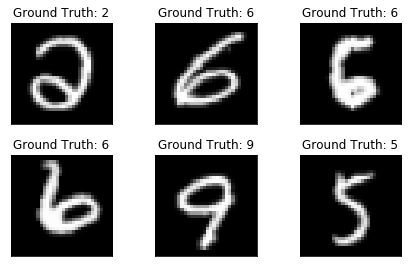

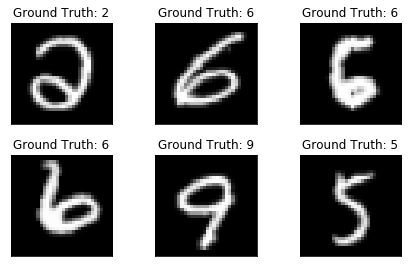

In [8]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

# Helper functions

In [9]:
def train(epoch, net, optimizer, train_loader, v=1, track=0):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if (v > 0) and (batch_idx % log_interval == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        if track > 0:
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
#         torch.save(network.state_dict(), 'model.pth')
#         torch.save(optimizer.state_dict(), 'optimizer.pth')

In [10]:
def test(net, optimizer, test_loader, v=1, track=0):
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    if track > 0:
        test_losses.append(test_loss)
    if v>0:
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct.item()/len(test_loader.dataset)

In [11]:
def kfold(k, N, epochs, model, optimizer, state_dict, train_loader):
    loss_avg = 0
    acc_avg = 0
    for i in range(k):
        model.load_state_dict(state_dict)
        epoch = 0
        count = 0
        min_error = 100
        max_acc = 1
        train_mask = []
        val_mask = []
        for i in range(60000):
            if i%k == 0:
                val_mask.append(i)
            else:
                train_mask.append(i)
        X_train = torch.utils.data.Subset(train_loader.dataset, train_mask)
        X_val = torch.utils.data.Subset(train_loader.dataset, val_mask)
        X_train_l = torch.utils.data.DataLoader(X_train, batch_size_train, True)
        X_val_l = torch.utils.data.DataLoader(X_val, batch_size_test, True)
        while (epoch < epochs and count < 1):
            train(epoch, model, optimizer, X_train_l, 0)
            test_loss, test_acc = test(model, optimizer, X_val_l, 0)
            epoch += 1
            if test_loss >= min_error:
                count += 1
            else:
                min_error = test_loss
                max_acc = test_acc
            print('{:.4f} - '.format(test_loss), end='')
        loss_avg += min_error
        acc_avg += max_acc
        print('{:.4f} ({:4.2f}%) |'.format(min_error, 100*max_acc), end='')
    print('>')
    return loss_avg/k, acc_avg/k

# Architectures

## MLP

In [12]:
class MLP(nn.Module):
    """MLP with 3 ReLU hidden layers and 1 softmax output layer"""
    
    def __init__(self, H, D):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H)
        self.fc4 = nn.Linear(H, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(D)
        
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = self.dropout(x)
        x = self.relu(self.fc1(x)) # H
        x = self.dropout(x)
        x = self.relu(self.fc2(x)) # H
        x = self.dropout(x)
        x = self.relu(self.fc3(x)) # H
        x = self.dropout(x)
        x = F.log_softmax(self.fc4(x)) # 10
        return x

## CNN

In [13]:
class CNN(nn.Module):
    """CNN inspired in LeNet 5"""
    def __init__(self, D):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(D)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # 6 @ 14x14
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) # 16 @ 5x5
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) # 120
        x = self.dropout(x)
        x = F.relu(self.fc2(x)) # 84
        x = self.dropout(x)
        x = self.fc3(x)         # 10
        return F.log_softmax(x)

# MLP

In [14]:
models = []
for H in [30, 60, 100, 300, 600]:
    for D in [0, 0.3, 0.5]:
        model = MLP(H, D)
        copy = MLP(H, D)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        print('D =', D, 'H =', H)
        loss, acc = kfold(3, 60000, 3, model, optimizer, copy.state_dict(), train_loader)
        print()
        models.append((H, D, loss, acc)) 

D = 0 H = 30


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0.2725 - 0.2352 - 0.2467 - 0.2352 (93.53%) |0.2905 - 0.2506 - 0.2445 - 0.2445 (93.55%) |0.3152 - 0.2805 - 0.2824 - 0.2805 (92.31%) |>

D = 0.3 H = 30
0.4920 - 0.4520 - 0.4447 - 0.4447 (88.63%) |0.6377 - 0.5603 - 0.5269 - 0.5269 (86.23%) |0.5472 - 0.4696 - 0.4504 - 0.4504 (88.59%) |>

D = 0.5 H = 30
1.1125 - 1.0562 - 1.0398 - 1.0398 (65.53%) |1.6664 - 1.5101 - 1.5143 - 1.5101 (43.65%) |1.4196 - 1.3426 - 1.3934 - 1.3426 (50.91%) |>

D = 0 H = 60
0.2166 - 0.2316 - 0.2166 (94.08%) |0.2829 - 0.2539 - 0.2561 - 0.2539 (93.26%) |0.2719 - 0.2430 - 0.2549 - 0.2430 (93.69%) |>

D = 0.3 H = 60
0.4119 - 0.4442 - 0.4119 (89.31%) |0.4748 - 0.4269 - 0.3991 - 0.3991 (89.89%) |0.5534 - 0.4695 - 0.4476 - 0.4476 (89.05%) |>

D = 0.5 H = 60
0.8407 - 0.7769 - 0.7910 - 0.7769 (79.74%) |1.0441 - 0.9722 - 0.9734 - 0.9722 (67.42%) |1.4523 - 1.5209 - 1.4523 (46.06%) |>

D = 0 H = 100
0.2775 - 0.2323 - 0.2182 - 0.2182 (94.65%) |0.3504 - 0.2819 - 0.3017 - 0.2819 (92.64%) |0.3064 - 0.2934 - 0.2848 - 0.2848 (92.58%)

In [15]:
models

[(30, 0, 0.253414995320638, 0.9313000000000001),
 (30, 0.3, 0.4739816345214844, 0.8781666666666667),
 (30, 0.5, 1.2974862274169923, 0.5336333333333333),
 (60, 0, 0.23782235209147137, 0.9367333333333333),
 (60, 0.3, 0.41952994588216147, 0.8941666666666667),
 (60, 0.5, 1.0671291147867839, 0.6440833333333333),
 (100, 0, 0.2616324279785156, 0.9329000000000001),
 (100, 0.3, 0.4622394027709961, 0.8819666666666667),
 (100, 0.5, 1.0759064259847004, 0.6448333333333333),
 (300, 0, 0.28911840845743814, 0.9235666666666665),
 (300, 0.3, 1.1542601018269856, 0.6116333333333334),
 (300, 0.5, 1.8065541147867838, 0.33283333333333337),
 (600, 0, 0.9600469210306803, 0.6516333333333334),
 (600, 0.3, 1.7190806854248049, 0.3570333333333333),
 (600, 0.5, 1.9979392415364583, 0.2462)]

In [16]:
mlp = MLP(300, 0)
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [17]:
test(mlp, optimizer, test_loader, v=1, track=1)
for epoch in range(1, n_epochs + 1):
    train(epoch, mlp, optimizer, train_loader, v=1, track=1)
    test(mlp, optimizer, test_loader, v=1, track=1)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.2957, Accuracy: 1434/10000 (14%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293908
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.828377
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.120316
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.576781
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.780068
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.409722
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.615798
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.771640
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.280584
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.598383
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.425468
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.398594
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.822862
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.406587
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.543218
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.347175
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.328592
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.333842
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.278531
Train Epoch: 1 [12160

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.408336
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.179815
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.225285
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.133584
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.305711
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.316391
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.178773
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.118329
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.184379
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.185830
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.415251
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.158725
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.295863
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.474574
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.205220
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.186540
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.168315
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.309589
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.217428
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.143316


Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.133967
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.153680
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.261790
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.272060
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.081561
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.130486
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.215561
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.174834
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.528462
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.068827
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.160174
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.267975
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.204988
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.224644
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.218772
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.190440
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.064474
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.203085
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.233602
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.228941


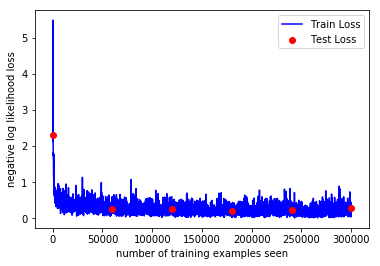

In [18]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue', zorder=1)
plt.scatter(test_counter, test_losses, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.savefig(os.path.join(image_dir, 'mlp.png'), bbox_inches='tight')
plt.show()

# CNN

In [19]:
models_cnn = []
for D in [0, 0.3, 0.5]:
    model = CNN(D)
    copy = CNN(D)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print('D =', D)
    loss, acc = kfold(3, 60000, 3, model, optimizer, copy.state_dict(), train_loader)
    print()
    models_cnn.append((D, loss, acc)) 

D = 0


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.1011 - 0.1071 - 0.1011 (97.17%) |0.1709 - 0.1416 - 0.1358 - 0.1358 (96.16%) |0.1823 - 0.0912 - 0.1163 - 0.0912 (97.55%) |>

D = 0.3
0.2009 - 0.1529 - 0.3236 - 0.1529 (95.43%) |0.3310 - 0.2714 - 0.2526 - 0.2526 (92.55%) |0.3159 - 0.2797 - 0.3051 - 0.2797 (91.53%) |>

D = 0.5
0.1495 - 0.1316 - 0.1519 - 0.1316 (96.50%) |0.1814 - 0.1436 - 0.1486 - 0.1436 (96.23%) |0.2175 - 0.2065 - 0.1707 - 0.1707 (95.63%) |>



In [20]:
models_cnn

[(0, 0.1093318229675293, 0.9695833333333335),
 (0.3, 0.2284045745849609, 0.9317166666666666),
 (0.5, 0.1486205348968506, 0.9611833333333334)]

In [21]:
train_losses_mlp = train_losses[:]
test_losses_mlp = test_losses[:]

In [22]:
cnn = CNN(0)
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [23]:
test(cnn, optimizer, test_loader, v=1, track=1)
for epoch in range(1, n_epochs + 1):
    train(epoch, cnn, optimizer, train_loader, v=1, track=1)
    test(cnn, optimizer, test_loader, v=1, track=1)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3074, Accuracy: 1040/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308661
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.929858
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.392244
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.444302
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.238617
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.182437
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.407515
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.182729
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.120806
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.138086
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.192416
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.167171
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.063673
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.344841
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.109396
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.124797
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.157725
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.408119
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.160221
Train Epoch: 1 [12160

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.082139
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.093173
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.035688
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.026231
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.007554
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.137152
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.059645
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.270992
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.048187
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.024769
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.153890
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.194046
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.025282
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.056307
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.091647
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.069623
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.130744
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.004695
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.058657
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.016162


Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.209238
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.214113
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.390071
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.366016
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.202008
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.356307
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.104435
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.216389
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.054747
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.057127
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.033046
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.006332
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.075904
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.050052
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.064004
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.091944
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.021100
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.000299
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.047629
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.002049


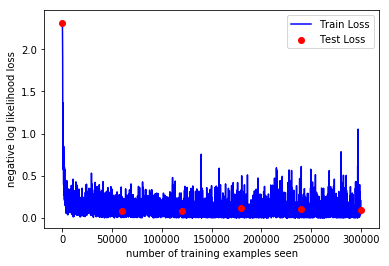

In [24]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue', zorder=1)
plt.scatter(test_counter, test_losses, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.savefig(os.path.join(image_dir, 'cnn.png'), bbox_inches='tight')
plt.show()

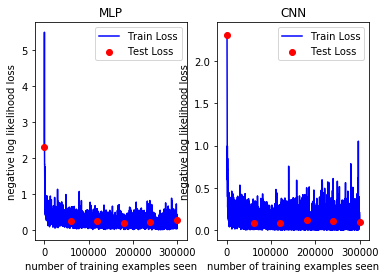

In [25]:
fig = plt.figure()

plt.subplot(1,2,1)
plt.plot(train_counter, train_losses_mlp, color='blue', zorder=1)
plt.scatter(test_counter, test_losses_mlp, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.title('MLP')

plt.subplot(1,2,2)
plt.plot(train_counter, train_losses, color='blue', zorder=1)
plt.scatter(test_counter, test_losses, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.title('CNN')

plt.savefig(os.path.join(image_dir, 'learning_curves.png'), bbox_inches='tight')